In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np

In [3]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden_layer1 = nn.Linear(2, 5)
    self.hidden_layer2 = nn.Linear(5, 5)
    self.hidden_layer3 = nn.Linear(5, 5)
    self.hidden_layer4 = nn.Linear(5, 5)
    self.hidden_layer5 = nn.Linear(5, 5)
    self.output_layer = nn.Linear(5, 1)

  def forward(self, x, t):
    inputs = torch.cat([x, t], axis=1)
    layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
    layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
    layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
    layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
    layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
    output = self.output_layer(layer5_out)
    return output

In [4]:
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [10]:
def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_x - 2*u_t - u
    return pde

In [11]:
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500, 1))
t_bc = np.zeros((500, 1))
u_bc = 6 * np.exp(-3 * x_bc)

In [12]:
iterations = 20000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)

    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)

    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))


    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    # Combining the loss functions
    loss = mse_u + mse_f


    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)

Streaming output truncated to the last 5000 lines.
15000 Traning Loss: tensor(4.7914e-05, device='cuda:0')
15001 Traning Loss: tensor(4.8682e-05, device='cuda:0')
15002 Traning Loss: tensor(4.4386e-05, device='cuda:0')
15003 Traning Loss: tensor(5.0431e-05, device='cuda:0')
15004 Traning Loss: tensor(9.9636e-05, device='cuda:0')
15005 Traning Loss: tensor(4.9347e-05, device='cuda:0')
15006 Traning Loss: tensor(4.7728e-05, device='cuda:0')
15007 Traning Loss: tensor(4.9885e-05, device='cuda:0')
15008 Traning Loss: tensor(4.6860e-05, device='cuda:0')
15009 Traning Loss: tensor(4.8990e-05, device='cuda:0')
15010 Traning Loss: tensor(4.6905e-05, device='cuda:0')
15011 Traning Loss: tensor(4.8148e-05, device='cuda:0')
15012 Traning Loss: tensor(4.9835e-05, device='cuda:0')
15013 Traning Loss: tensor(5.0822e-05, device='cuda:0')
15014 Traning Loss: tensor(4.8651e-05, device='cuda:0')
15015 Traning Loss: tensor(4.7915e-05, device='cuda:0')
15016 Traning Loss: tensor(4.5661e-05, device='cuda:0

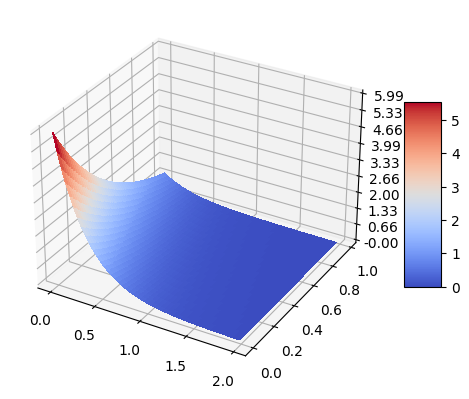

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Generate data
x = np.arange(0, 2, 0.02)
t = np.arange(0, 1, 0.02)
ms_x, ms_t = np.meshgrid(x, t)

# Reshape data for compatibility with torch
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)

# Convert data to tensors and move to device
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)

# Evaluate the network
pt_u = net(pt_x, pt_t)

# Extract the data from the tensor
u = pt_u.data.cpu().numpy()

# Reshape data for plotting
ms_u = u.reshape(ms_x.shape)

# Plot the surface
surf = ax.plot_surface(ms_x, ms_t, ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set the z-axis formatting
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)

# Show the plot
plt.show()